# MultiSigBERT

This notebook accompanies the anonymous submission:

**MultiSigBERT: Beyond Survival Analysis through Multimodal and Sequential Modeling in Oncology**  
(ECML-PKDD 2026, double-blind review)

It provides an end-to-end demonstration of the pipeline: data preprocessing, multimodal sequential feature construction, survival modeling, and evaluation.

---

## Clinical Data Confidentiality Notice

Due to clinical confidentiality constraints and applicable data protection regulations (e.g., GDPR), we cannot share real patient-level clinical data used in the study.

To support reproducibility, this notebook is designed to run with:
- a **synthetic dataset** generated with the same schema and statistical structure as the real cohort, or
- a **user-provided dataset** following the format described in `data/README.md`.

No identifying information is included in this repository.


Landmark-Based Survival MultiModelling
---


| Patient | date $t$ | Sentence embedding $v \in \mathbb{R}^q$ | $D \in \{0,1\}$ | $T \ge 0$ |
|:--------|:-----------:|:------------------------------------------:|:-----------------:|:------------:|
| $i$ |$\begin{aligned} &t_1 \\ &\vdots \\ &t_N \end{aligned}$| $\begin{aligned} &v^i_{t_1} \\ &\vdots \\ &v^i_{t_N} \end{aligned}$ | $\delta_i$ | $T_i$ |


Let each patient $i$ be described by a sequence of sentence embeddings $v_t^i \in \mathbb{R}^p$ observed at times $t$, an event indicator $\delta_i \in \{0,1\}$, and a survival time $T_i \ge 0$.
We aim to estimate short-term survival probabilities at a fixed **landmark time** $L$ using information available up to $L$.

### Formal Table - Landmark-Specific Cohort at $L$ Months

| Patient $i$ | Report time $t$ | Embedding $v_t^i \in \mathbb{R}^p$ | Event indicator $\delta_i(L)$ | Total survival time $T_i \ge 0$ | Residual time $R_i = T_i - L$ | Days since start $(t - t_{\text{start},i})$ | Short-history flag $\gamma_i(L)$ | **Landmark $L$** |
|:--------------:|:-----------------:|:-------------------------------------:|:--------------------------------:|:--------------------------------:|:--------------------------------:|:--------------------------------------------:|:----------------------------------:|:------------------:|
| $i$ | $t_1 \in [L-w,L]$ | $v_{t_1}^i$ | $\delta_i(L)$ | $T_i$ | $T_i - L$ | $(t_1 - t_{\text{start},i})$ | $\gamma_i(L)$ | $L$ |
|  | $t_2 \in [L-w,L]$ | $v_{t_2}^i$ | $\delta_i(L)$ | $T_i$ | $T_i - L$ | $(t_2 - t_{\text{start},i})$ | $\gamma_i(L)$ | $L$ |
|  | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ | $L$ |
|  | $t_N \in [L-w,L]$ | $v_{t_N}^i$ | $\delta_i(L)$ | $T_i$ | $T_i - L$ | $(t_N - t_{\text{start},i})$ | $\gamma_i(L)$ | $L$ |

---

**Interpretation**

- $L$: applied landmark time (same for all rows in this cohort).  
- Reports restricted to $t \in [L-w,\,L]$.  
- Patients included only if $T_i \ge L$ (alive at the landmark).  
- $R_i = T_i - L$: residual survival time beyond the landmark.  
- $\gamma_i(L)$: 1 if less than $w$ months of history before $L$.  
- This table represents the DataFrame `df_L` returned by  
  ```python
  define_landmark_cohort(df_OG2,
                         landmark_months=L,
                         window_months=w)

In [1]:
import types
import sys
from numbers import Real, Integral

# Create a fake module to emulate 'sklearn.utils._param_validation'
# (used by skglm in newer versions of scikit-learn, >=1.3)
param_validation = types.ModuleType("sklearn.utils._param_validation")

# Define a minimal replacement for Interval used in _parameter_constraints
class Interval:
    def __init__(self, dtype, left, right, closed="neither"):
        self.dtype = dtype
        self.left = left
        self.right = right
        self.closed = closed

# Define a minimal replacement for StrOptions used in _parameter_constraints
class StrOptions:
    def __init__(self, options):
        self.options = set(options)

# Add the custom classes to the fake module
param_validation.Interval = Interval
param_validation.StrOptions = StrOptions

# Inject the fake module into sys.modules before skglm is imported
# This prevents skglm from raising an ImportError if sklearn < 1.3
sys.modules["sklearn.utils._param_validation"] = param_validation

In [2]:
import pandas as pd
import torch
import numpy as np
import time
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os

# Add the src directory to the Python path
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
src_path = os.path.abspath(os.path.join(notebook_dir, '..', 'src/sigbert'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Now import our custom modules
from _utils import *
from descriptive_stats_pkg import *
from compression_pkg import *
from survival_analysis_pkg import *
from metrics_plot_results_pkg import *

/Applications/anaconda3/envs/sigbert-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
start_notebook = time.time()

# I) Data Importation

In [5]:
df_OG = global_data_import(path_import = "...", nrows=None)


----- Total import time: 86.85 seconds (1.45 minutes)
Number of unique patients: 7121


In [6]:
df_OG = convert_date_columns(df_OG)

In [8]:
df_OG2, df_surv = compute_survival_time(df_OG, verbose=False)

In [9]:
results_summary = []

# MultiModal LandMark

## Import Strutured Data 

In [10]:
path_seq = './donnees-evolutives.csv' # Table of sequential structured data
ippr_conforme = pd.read_csv('./patients_conformes.csv') # ID of studied patients 

In [11]:
df_seq, mapping_type_libelle = load_sequence_data(
    path_seq,
    ippr_conforme,
    id_col_original = "IPPR",
    id_col_final = "ID")

In [12]:
covariables_list = ['PO', 'KAR', 'PS', 'IMC', 'TA', 'PL', 'TAI']
ordinal_codes=["PS", "KAR"]

In [13]:
df_wide, mapping_libelle_filtered = build_wide_table_and_metadata(
    df_seq=df_seq,
    mapping_type_libelle=mapping_type_libelle,
    ordinal_codes=ordinal_codes,
    covariables_list=covariables_list)

## Process sur `df_meta`

In [14]:
# Import the survival metadata
df_meta = pd.read_csv('./survival_metadata_by_patient.csv')
df_meta = df_meta.rename(columns={'IPPR': 'ID'})

In [15]:
# Merge the metadata into the main study dataframe using a left join on 'IPPR'
df_wide_meta = df_wide.merge(df_meta, on='ID', how='left')

# Display the first 3 rows of the merged dataframe
# df_wide_meta.head(3)

# Rename 'DATE_DONNEE' into 'date_creation'
df_wide_meta = df_wide_meta.rename(columns={'DATE_DONNEE': 'date_creation'})

df_wide_meta = convert_date_columns(df_wide_meta)

In [ ]:
df_merge = df_OG2.merge(df_wide_meta[['ID'] + covariables_list], on='ID', how='left')

In [17]:
df_merge_clean = deduplicate_by_timestamp(
    df_merge=df_merge,
    covariables_list=covariables_list,
    var_id="ID",
    var_crea="date_creation",
    var_embd="embeddings"
)

Found 18142571 duplicated rows sharing the same (ID, date_creation). Proceeding to deduplicate...
Deduplication done: 18142571 rows affected.


In [18]:
seq_var_patients_list = df_wide_meta['ID'].dropna().unique().tolist()
df_merge_clean = df_merge_clean[df_merge_clean['ID'].isin(seq_var_patients_list)].copy()
df_merge_clean['ID'].nunique()

7074

In [ ]:
df_multimodal = df_merge_clean.copy()
df_multimodal = df_multimodal.reset_index(drop=True)

In [20]:
print(f"Avaiblable patient for MultiModal: {df_multimodal['ID'].nunique()}")

Avaiblable patient for MultiModal: 7074


In [21]:
# ----------------------- :: Reports Only – Landmark Analysis :: -----------------------
k_comp = 25; max_reports = 221
L_chosen = 36; w_chosen = 12

print(f" ---------- :: Reports Only :: ----------\n ---------- L_chosen = {L_chosen}; w_chosen = {w_chosen} ---------- ")

# Build the landmark cohort
df_L, patients_L, df_gamma_L = define_landmark_cohort(
    df_multimodal,
    landmark_months=L_chosen,
    window_months=w_chosen
)

# Count number of clinical reports in the window
df_counts = (
    df_L.groupby("ID")
        .size()
        .reset_index(name="n_reports")
)
mean_reports = df_counts["n_reports"].mean()
std_reports = df_counts["n_reports"].std(ddof=1)

# Train-test construction
df_train_new_OG, test_groups = make_train_test(df_L)

# PCA compression
_, R_comp = pca_compression(df_train_new_OG, k_comp, verbose=True)

df_all = df_L.copy()

 ---------- :: Reports Only :: ----------
 ---------- L_chosen = 36; w_chosen = 12 ---------- 
[Landmark 36 mo] Patients kept: 3674/7074 (3400 excluded)
  → Short-history γ=1: 2473/3674 = 67.3%
  → Observations kept: 19448/146132 (13.3% retained, 86.7% removed)
  → Residual survival R_i computed (min=0.0 days).
  → Landmark events computed: DEATH_L sum = 15453.
Compression dimension (bar_p): 25
Explained variance ratio: 97.0109%


## Only Reports


### Processing for max_reports = 221 ###

Total number of individuals in the train set: 1263
Total number of individuals in the validation set: 1264

Timestamps normalized for each patient to the [0, 1] range.
Number of patients after interpolation:1263
Number of signature components (order 2): 702
Percentage of rows with NaNs in signature columns: 0.00%
Number of events (deaths): 807 out of 1263 (63.90%)
Number of individuals in training: 1263
Signature feature computation took 3.58s

 --------------- Linear LASSO training --------------- 
 --------> X.shape: (1263, 703)

 --------> y.shape: (1263, 2)



/Applications/anaconda3/envs/sigbert-env/lib/python3.8/site-packages/skglm/solvers/prox_newton.py:433: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  grad[idx] = X[:, j] @ raw_grad


Number of nonzero coefficients in solution: 52 out of 703.
w_sk.shape: (703,)
---
NaNs in risk_score: 0
Infs in risk_score: 0
C-index on training data: 0.776
Execution time: 15.92 seconds (0.27 minutes)

        Scores:
        C-index        = 0.776
        Log-likelihood = -3.75
        
 ---------------  --------------- 
Timestamps normalized for each patient to the [0, 1] range.
Number of patients after interpolation:127
Number of signature components (order 2): 702
Percentage of rows with NaNs in signature columns: 0.00%
Number of events (deaths): 82 out of 127 (64.57%)

--- Test Case 1 for max_reports = 221 ---
---
NaNs in risk_score: 0
Infs in risk_score: 0
Concordance index on test set: 0.755
--- ---
Timestamps normalized for each patient to the [0, 1] range.
Number of patients after interpolation:127
Number of signature components (order 2): 702
Percentage of rows with NaNs in signature columns: 0.00%
Number of events (deaths): 91 out of 127 (71.65%)

--- Test Case 2 for max_r

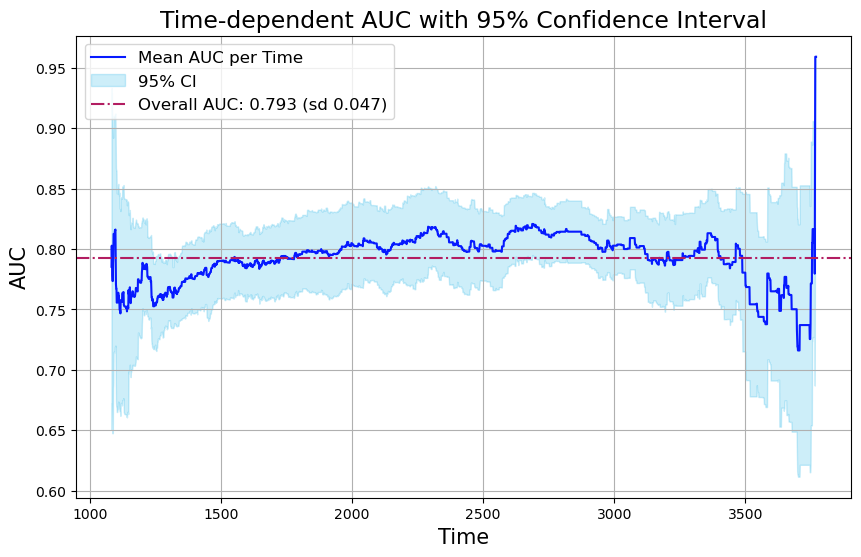

Computing Brier Scores: 100%|███████████████████| 10/10 [00:01<00:00,  6.77it/s]



=== Brier Score Summary ===
Mean BS across tests: 0.1718
BS range: [0.0000 ;  0.4607]



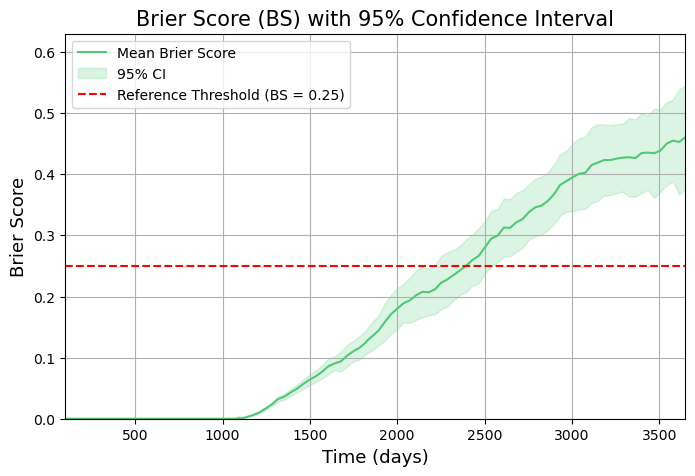

In [22]:
# Store results
c_index_test_results_RO = []
df_survival_test_list_RO = []
lambda_l1_CV_RO = 0.35

start_RO = time.time()

start_learning_process_RO = time.time()

(
    df_results_RO,               # Summary metrics
    cph_RO,                      # Cox model
    df_survival_RO,              # Survival DF (train)
    w_sk_RO,                     # Train risk scores
    scores_RO,                   # Signature importance
    X_RO,                        # Train design matrix
    y_train_RO,                  # y raw (event, time)
    y_cox_RO,                    # y backend
    c_index_train_RO,            # Train C-index
    c_index_test_list_RO,        # Test C-indices (per fold)
    c_index_test_mean_RO,        # Mean C-index
    c_index_test_std_RO,         # Std C-index
    df_survival_test_list_RO,    # Test survival DFs
    df_study_all_RO
) = global_sigbert_process(
    max_reports           = max_reports,
    df_all                = df_all,
    df_train_new_OG       = df_train_new_OG,
    test_groups           = test_groups,
    R_comp                = R_comp,
    lambda_l1_CV          = lambda_l1_CV_RO,
    print_progress        = False,
    order_sign            = 2,
    var_duration          = 'R',

    # REPORTS ONLY → no structured sequences
    var_struct_seq_list   = None,
    df_matrix_covar       = df_gamma_L,   # static duration info only
    use_other_covar       = True,         # keep duration R if needed

    use_standard_scale    = False,
)

end_learning_process_RO = time.time() - start_learning_process_RO
print(
    f"\nLearning process completed in "
    f"{end_learning_process_RO/60:.2f} minutes "
    f"({end_learning_process_RO:.1f} seconds)."
)

# ------------------------------------------------------------------
# Post-processing (Reports Only)
# ------------------------------------------------------------------

non_nuls_coefs_RO = int((w_sk_RO != 0).sum())

lower_bound_RO, upper_bound_RO = jackknife_confidence_interval(
    c_index_test_list_RO
)
print(f"Jackknife Confidence Interval (95%): [{lower_bound_RO:.4f}, {upper_bound_RO:.4f}]")

df_survival_test_overall_RO = pd.concat(df_survival_test_list_RO, axis=0)
df_survival_all_RO = pd.concat(
    [df_survival_RO, df_survival_test_overall_RO]
)

mean_auc_list_RO, _, _, _ = plot_dynamic_auc(
    y_train_RO,
    df_survival_test_list_RO,
    test_groups,
    export_fig=None
)

evaluation_times = np.sort(np.unique(np.concatenate((
    np.linspace(100, 3650, 100),
    [365, 730, 1095, 1825, 3650]
))))

brier_scores_array_RO, bs_mean_RO, bs_std_RO, bs_upper_RO, bs_lower_RO = evaluate_brier_score_multiple_tests(
    df_survival_test_list = df_survival_test_list_RO,
    cph                  = cph_RO,
    evaluation_times     = evaluation_times,
    brier_score_function = brier_score_ipcw_with_cph,
    export_fig           = False,
    path_export_fig      = "../results/brier_score_tests.png",
    verbose              = True
)

IBS_3y_RO = bs_mean_RO[np.where(evaluation_times == 1095)[0][0]]

nbr_patients_RO = pd.concat(
    [df_survival_RO['ID'], *(df['ID'] for df in df_survival_test_list_RO)]
).nunique()

duration_RO = (time.time() - start_RO) / 60

results_summary.append({
    "Setting": "Landmark + Reports Only",
    "nbr_patients": nbr_patients_RO,
    "lambda_LASSO": lambda_l1_CV_RO,
    "non_nuls_coefs": non_nuls_coefs_RO,
    "total_coefs": len(w_sk_RO),
    "C-index Train": f"{c_index_train_RO:.3f}",
    "Mean C-index (Test)": f"{c_index_test_mean_RO:.3f} (sd {c_index_test_std_RO:.3f})",
    "Jackknife CI 95%": f"[{lower_bound_RO:.3f}, {upper_bound_RO:.3f}]",
    "Mean td-AUC": np.round(np.mean(mean_auc_list_RO), 3),
    "IBS@3y": np.round(IBS_3y_RO, 4),
    "Execution Time (min)": np.round(duration_RO, 2)
})

## MultiModal Learning

 ---------- :: MultiModal :: ----------
  ---------- L_chosen = 36; w_chosen = 12 ---------- 

### Processing for max_reports = 221 ###

Total number of individuals in the train set: 1263
Total number of individuals in the validation set: 1264

Timestamps normalized for each patient to the [0, 1] range.
Number of patients after interpolation:1263
Number of signature components (order 2): 1122
Percentage of rows with NaNs in signature columns: 0.00%
Number of events (deaths): 807 out of 1263 (63.90%)
Number of individuals in training: 1263
Signature feature computation took 6.87s

 --------------- Linear LASSO training --------------- 
 --------> X.shape: (1263, 1123)

 --------> y.shape: (1263, 2)

Number of nonzero coefficients in solution: 129 out of 1123.
w_sk.shape: (1123,)
---
NaNs in risk_score: 0
Infs in risk_score: 0
C-index on training data: 0.779
Execution time: 19.33 seconds (0.32 minutes)

        Scores:
        C-index        = 0.779
        Log-likelihood = -3.74
       

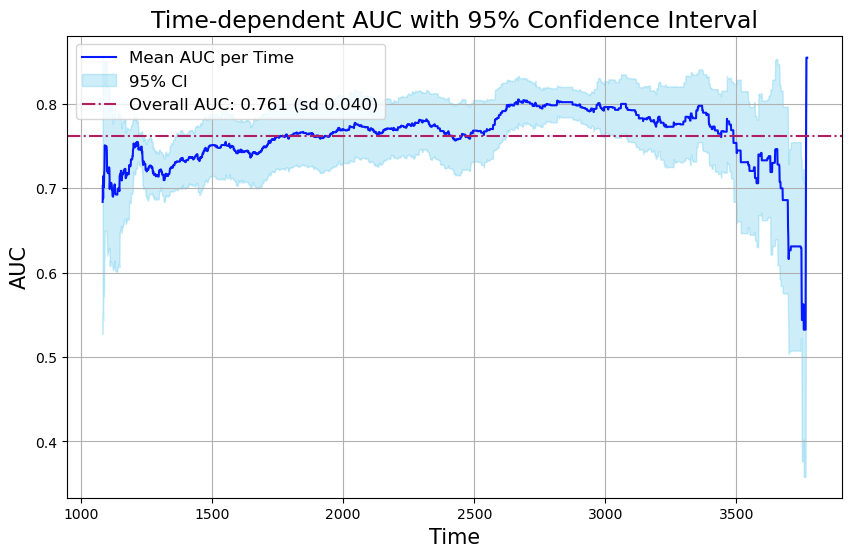

Computing Brier Scores: 100%|███████████████████| 10/10 [00:01<00:00,  6.48it/s]



=== Brier Score Summary ===
Mean BS across tests: 0.2063
BS range: [0.0000 ;  0.5364]



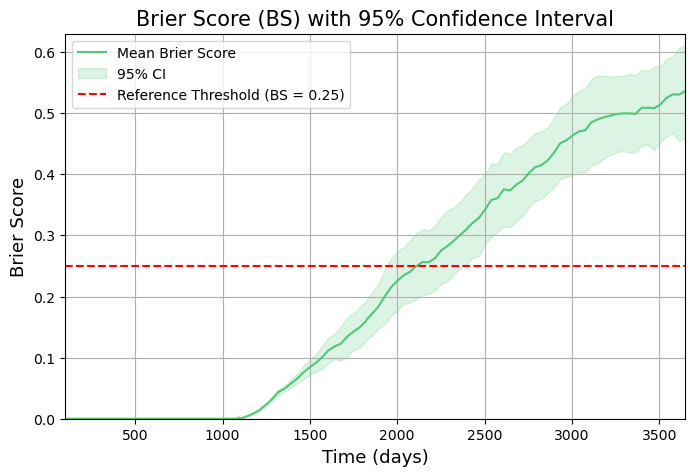

In [23]:
start = time.time()

print(f" ---------- :: MultiModal :: ----------\n  ---------- L_chosen = {L_chosen}; w_chosen = {w_chosen} ---------- ")

# Store results
c_index_test_results_both = []
df_survival_test_list_both = []
lambda_l1_CV_both = 0.75

start_learning_process_both = time.time()

(
    df_results_both,               # Summary metrics
    cph_both,                      # Cox model
    df_survival_both,              # Train survival DF
    w_sk_both,                     # Train risk scores
    scores_both,                   # Feature importance
    X_both,                        # Train design matrix
    y_train_both,                  # y (event, time) raw
    y_cox_both,                    # y for backend
    c_index_train_both,            # Train C-index
    c_index_test_list_both,        # Test C-index per fold
    c_index_test_mean_both,        # Mean C-index
    c_index_test_std_both,         # Std C-index
    df_survival_test_list_both,    # Survival per fold
    df_study_all_both
) = global_sigbert_process(
    max_reports           = max_reports,
    df_all                = df_all,
    df_train_new_OG       = df_train_new_OG,
    test_groups           = test_groups,
    R_comp                = R_comp,
    lambda_l1_CV          = lambda_l1_CV_both,
    print_progress        = False,
    order_sign            = 2,
    var_duration          = 'R',
    var_struct_seq_list   = covariables_list,
    df_matrix_covar       = df_gamma_L,
    use_other_covar       = True,
    use_standard_scale    = False,
)

end_learning_process_both = time.time() - start_learning_process_both
print(
    f"\nLearning process completed in "
    f"{end_learning_process_both/60:.2f} minutes "
    f"({end_learning_process_both:.1f} seconds)."
)

# ------------------------------------------------------------------
# Post-processing
# ------------------------------------------------------------------

non_nuls_coefs_all = int((w_sk_both != 0).sum())

lower_bound_both, upper_bound_both = jackknife_confidence_interval(
    c_index_test_list_both
)
print(f"Jackknife Confidence Interval (95%): [{lower_bound_both:.4f}, {upper_bound_both:.4f}]")

df_survival_test_overall_both = pd.concat(df_survival_test_list_both, axis=0)
df_survival_all_both = pd.concat(
    [df_survival_both, df_survival_test_overall_both]
)

mean_auc_list_both, _, _, _ = plot_dynamic_auc(
    y_train_both,
    df_survival_test_list_both,
    test_groups,
    export_fig=None
)

evaluation_times = np.sort(np.unique(np.concatenate((
    np.linspace(100, 3650, 100),
    [365, 730, 1095, 1825, 3650]
))))

brier_scores_array_both, bs_mean_both, bs_std_both, bs_upper_both, bs_lower_both = evaluate_brier_score_multiple_tests(
    df_survival_test_list = df_survival_test_list_both,
    cph                  = cph_both,
    evaluation_times     = evaluation_times,
    brier_score_function = brier_score_ipcw_with_cph,
    export_fig           = False,
    path_export_fig      = "../results/brier_score_tests.png",
    verbose              = True
)

IBS_3y_both = bs_mean_both[np.where(evaluation_times == 1095)[0][0]]

nbr_patients_both = pd.concat(
    [df_survival_both['ID'], *(df['ID'] for df in df_survival_test_list_both)]
).nunique()

duration = (time.time() - start) / 60

results_summary.append({
    "Setting": "Landmark + Reports & Seq Structured Data",
    "nbr_patients": nbr_patients_both,
    "lambda_LASSO": lambda_l1_CV_both,
    "non_nuls_coefs": non_nuls_coefs_all,
    "total_coefs": len(w_sk_both),
    "C-index Train": f"{c_index_train_both:.3f}",
    "Mean C-index (Test)": f"{c_index_test_mean_both:.3f} (sd {c_index_test_std_both:.3f})",
    "Jackknife CI 95%": f"[{lower_bound_both:.3f}, {upper_bound_both:.3f}]",
    "Mean td-AUC": np.round(np.mean(mean_auc_list_both), 3),
    "IBS@3y": np.round(IBS_3y_both, 4),
    "Execution Time (min)": np.round(duration, 2)
})

In [24]:
df_summary = pd.DataFrame(results_summary)
df_summary

,Setting,nbr_patients,lambda_LASSO,non_nuls_coefs,total_coefs,C-index Train,Mean C-index (Test),Jackknife CI 95%,Mean td-AUC,IBS@3y,Execution Time (min)
0,Landmark + Reports Only,2527,0.35,52,703,0.776,0.760 (sd 0.028),"[0.742, 0.777]",0.793,0.0008,0.47
1,Landmark + Reports & Seq Structured Data,2527,0.75,129,1123,0.779,0.732 (sd 0.025),"[0.717, 0.748]",0.761,0.0008,0.62


In [27]:
duration_notebook = time.time() - start_notebook
print(f" NoteBook total duration: {duration_notebook:.2f}s i.e. {duration_notebook / 60:.2f}min.")

 NoteBook total duration: 189.11s i.e. 3.15min.
